In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
base_dir ='cat_dog'

train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/anaconda3/envs/tf-metal/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [5]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

2025-05-27 14:55:31.824583: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-27 14:55:31.824618: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-27 14:55:31.824628: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-27 14:55:31.824650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-27 14:55:31.824662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [7]:
from tensorflow.keras.optimizers import Adam

model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,524,289 (13.44 MB)

 Trainable params: 295,425 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [8]:
model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5


/opt/anaconda3/envs/tf-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-27 14:55:33.746589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


251/251 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - accuracy: 0.7807 - loss: 0.6125 - val_accuracy: 0.9812 - val_loss: 0.0564
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9508 - loss: 0.1558 - val_accuracy: 0.9832 - val_loss: 0.0505
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.9653 - loss: 0.1094 - val_accuracy: 0.9876 - val_loss: 0.0434
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 59s 234ms/step - accuracy: 0.9696 - loss: 0.1005 - val_accuracy: 0.9876 - val_loss: 0.0457
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.9690 - loss: 0.1164 - val_accuracy: 0.9867 - val_loss: 0.0486


In [9]:
y_pred_prob = model.predict(test_generator)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)
y_true = test_generator.classes

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step


              precision    recall  f1-score   support

        cats       0.98      0.99      0.99      1011
        dogs       0.99      0.98      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023



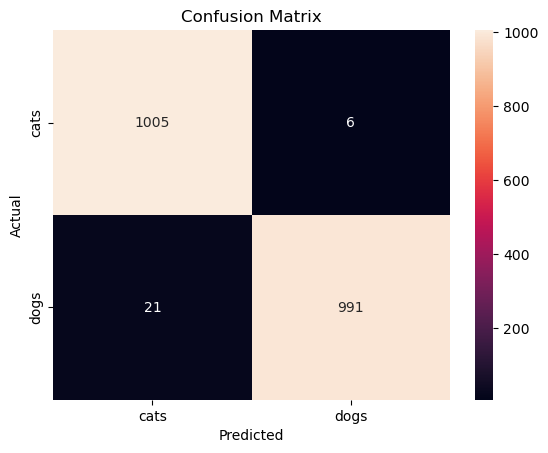

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
!du -hs *h5

 16M	cat_dog_classifier.weights.h5
